<a href="https://colab.research.google.com/github/Dark-Sied/Intent_Classification/blob/master/Intent_classification_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

import os
import numpy as np
import pandas as pd
import nltk
import re
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib
import csv

Using TensorFlow backend.


In [2]:
def load_dataset(filename):
    df = pd.read_csv(filename, encoding = "latin1", names = ["Sentence", "Intent"])
    df.head()
    intent = df["Intent"]
    unique_intent = list(set(intent))
    sentences = list(df["Sentence"])
    return (intent, unique_intent, sentences)

In [3]:
intent, unique_intent, sentences = load_dataset("/home/ehwa009/catkin_ws/nao_ws/src/social_mind/motion_arbiter/data/intent_data.csv")
# intent, unique_intent, sentences = load_dataset("Dataset.csv")
print(unique_intent)

[u'multiple_choice', u'welcome', u'request', u'greeting', u'inform', u'confirm_answer', u'thanks', u'closing']


In [4]:
print(sentences[:5])

[u'Hello  i was wondering if you can tell me where a good restaurant is to book ', u'Sure  How many people are in your party ', u'Success  Your reservation has been confirmed  Please enjoy your meal ', u'Great  What city are you dining in ', u'What is the price range of The Rock Wood Fired Pizza ']


In [5]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ehwa009/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ehwa009/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [6]:
#define stemmer
stemmer = LancasterStemmer()

In [7]:
def cleaning(sentences):
    words = []
    for s in sentences:
        # clean = re.sub(r'[^ a-z A-Z 0-9]', " ", s)
        # w = word_tokenize(clean)
        w = word_tokenize(str(s))
        #stemming
        words.append([i.lower() for i in w])
    return words 

In [8]:
cleaned_words = cleaning(sentences)
print(len(cleaned_words))
print(cleaned_words[:5])  

19571
[['hello', 'i', 'was', 'wondering', 'if', 'you', 'can', 'tell', 'me', 'where', 'a', 'good', 'restaurant', 'is', 'to', 'book'], ['sure', 'how', 'many', 'people', 'are', 'in', 'your', 'party'], ['success', 'your', 'reservation', 'has', 'been', 'confirmed', 'please', 'enjoy', 'your', 'meal'], ['great', 'what', 'city', 'are', 'you', 'dining', 'in'], ['what', 'is', 'the', 'price', 'range', 'of', 'the', 'rock', 'wood', 'fired', 'pizza']]


In [9]:
def create_tokenizer(words, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~'):
    token = Tokenizer(filters = filters)
    token.fit_on_texts(words)
    return token

In [10]:
def check_max_length(words):
    return(len(max(words, key = len)))

In [11]:
word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(word_tokenizer.word_index) + 1
max_length = check_max_length(cleaned_words)

print("Vocab Size = %d and Maximum length = %d" % (vocab_size, max_length))

Vocab Size = 5795 and Maximum length = 25


In [12]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [13]:
encoded_doc = encoding_doc(word_tokenizer, cleaned_words)
print(encoded_doc[:5])

[[106, 2, 107, 369, 127, 1, 21, 112, 29, 139, 5, 47, 18, 15, 4, 19], [108, 23, 27, 22, 24, 7, 8, 30], [152, 8, 14, 59, 81, 69, 16, 44, 8, 50], [31, 11, 52, 24, 1, 168, 7], [11, 15, 12, 211, 199, 34, 12, 235, 1364, 2087, 205]]


In [14]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [15]:
padded_doc = padding_doc(encoded_doc, max_length)

In [16]:
padded_doc[:5]

array([[ 106,    2,  107,  369,  127,    1,   21,  112,   29,  139,    5,
          47,   18,   15,    4,   19,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 108,   23,   27,   22,   24,    7,    8,   30,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 152,    8,   14,   59,   81,   69,   16,   44,    8,   50,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [  31,   11,   52,   24,    1,  168,    7,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [  11,   15,   12,  211,  199,   34,   12,  235, 1364, 2087,  205,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0]], dtype=int32)

In [17]:
print("Shape of padded docs = ",padded_doc.shape)

('Shape of padded docs = ', (19571, 25))


In [18]:
#tokenizer with filter changed
output_tokenizer = create_tokenizer(unique_intent, filters = '!"#$%&()*+,-/:;<=>?@[\]^`{|}~')


In [19]:
output_tokenizer.word_index

{u'closing': 8,
 u'confirm_answer': 6,
 u'greeting': 4,
 u'inform': 5,
 u'multiple_choice': 1,
 u'request': 3,
 u'thanks': 7,
 u'welcome': 2}

In [20]:
encoded_output = encoding_doc(output_tokenizer, intent)
print(encoded_output[:5])

[[3], [3], [5], [3], [3]]


In [21]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)

In [22]:
encoded_output.shape

(19571, 1)

In [23]:
def one_hot(encode):
    o = OneHotEncoder(sparse = False)
    return(o.fit_transform(encode))

In [24]:
output_one_hot = one_hot(encoded_output)
print(output_one_hot[:5])

[[0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]]


In [25]:
output_one_hot.shape

(19571, 8)

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, test_size = 0.2)


In [28]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (15656, 25) and train_Y = (15656, 8)
Shape of val_X = (3915, 25) and val_Y = (3915, 8)


In [29]:
def create_model(vocab_size, max_length):
    model = Sequential()
    model.add(Embedding(vocab_size, 128, input_length = max_length, trainable = False))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25)))
#     model.add(LSTM(128, dropout=0.25, recurrent_dropout=0.25))
    model.add(Dense(32, activation = "relu"))
#     model.add(Dropout(0.5))
    model.add(Dropout(0.25))
    model.add(Dense(8, activation = "softmax"))

    return model

In [30]:
model = create_model(vocab_size, max_length)
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 25, 128)           741760    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
Total params: 1,013,416
Trainable params: 271,656
Non-trainable params: 741,760
_________________________________________________________________


In [31]:
save_path = '/home/ehwa009/catkin_ws/nao_ws/src/social_mind/motion_arbiter/config/model.h5'

checkpoint = ModelCheckpoint(save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [32]:
hist = model.fit(train_X, train_Y, epochs = 100, batch_size = 32, validation_data = (val_X, val_Y), callbacks = [checkpoint, early_stopping])

Train on 15656 samples, validate on 3915 samples
Epoch 1/100
15656/15656 [==============================] - 18s 1ms/step - loss: 0.8992 - acc: 0.7088 - val_loss: 0.6207 - val_acc: 0.8143

Epoch 00001: val_loss improved from inf to 0.62073, saving model to /home/ehwa009/catkin_ws/nao_ws/src/social_mind/motion_arbiter/config/model.h5
Epoch 2/100
15656/15656 [==============================] - 16s 1ms/step - loss: 0.6371 - acc: 0.8134 - val_loss: 0.5139 - val_acc: 0.8337

Epoch 00002: val_loss improved from 0.62073 to 0.51391, saving model to /home/ehwa009/catkin_ws/nao_ws/src/social_mind/motion_arbiter/config/model.h5
Epoch 3/100
15656/15656 [==============================] - 15s 978us/step - loss: 0.5334 - acc: 0.8325 - val_loss: 0.4491 - val_acc: 0.8503

Epoch 00003: val_loss improved from 0.51391 to 0.44911, saving model to /home/ehwa009/catkin_ws/nao_ws/src/social_mind/motion_arbiter/config/model.h5
Epoch 4/100
15656/15656 [==============================] - 16s 1ms/step - loss: 0.4970

15656/15656 [==============================] - 13s 843us/step - loss: 0.2639 - acc: 0.8982 - val_loss: 0.2783 - val_acc: 0.9009

Epoch 00032: val_loss improved from 0.28155 to 0.27829, saving model to /home/ehwa009/catkin_ws/nao_ws/src/social_mind/motion_arbiter/config/model.h5
Epoch 33/100
15656/15656 [==============================] - 13s 842us/step - loss: 0.2588 - acc: 0.8985 - val_loss: 0.2900 - val_acc: 0.8996

Epoch 00033: val_loss did not improve from 0.27829
Epoch 34/100
15656/15656 [==============================] - 13s 825us/step - loss: 0.2541 - acc: 0.9016 - val_loss: 0.2855 - val_acc: 0.8978

Epoch 00034: val_loss did not improve from 0.27829
Epoch 35/100
15656/15656 [==============================] - 13s 832us/step - loss: 0.2546 - acc: 0.9016 - val_loss: 0.2766 - val_acc: 0.8971

Epoch 00035: val_loss improved from 0.27829 to 0.27663, saving model to /home/ehwa009/catkin_ws/nao_ws/src/social_mind/motion_arbiter/config/model.h5
Epoch 36/100
15656/15656 [=================

In [33]:
model = load_model(save_path)

In [34]:
scores = model.evaluate(val_X, val_Y, verbose=0)
print("Accuracy: %.2f%%"%(scores[1]*100))

Accuracy: 89.94%


In [35]:
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [36]:
y_pred = model.predict_classes(val_X)

print(y_pred)

target_names = unique_intent

print(classification_report(np.argmax(val_Y,axis=1), y_pred, target_names=target_names))
# confusion_matrix = confusion_matrix(np.argmax(val_Y, axis=1), y_pred)
# print(confusion_matrix)

[2 2 2 ... 3 2 2]
                 precision    recall  f1-score   support

multiple_choice       0.80      0.76      0.78        51
        welcome       0.80      1.00      0.89         4
        request       0.92      0.93      0.92      1855
       greeting       0.60      0.26      0.36       113
         inform       0.90      0.95      0.92      1671
 confirm_answer       0.78      0.43      0.56       116
         thanks       0.88      0.81      0.84        88
        closing       0.68      0.76      0.72        17

    avg / total       0.89      0.90      0.89      3915



In [37]:
import scikitplot as skplt
# skplt.metrics.plot_confusion_matrix(np.argmax(val_Y, axis=1), y_pred, normalize=True, 
#                                     figsize=(14,11))
# plt.show()

In [38]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
#     fig.tight_layout()
    return ax

Normalized confusion matrix


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


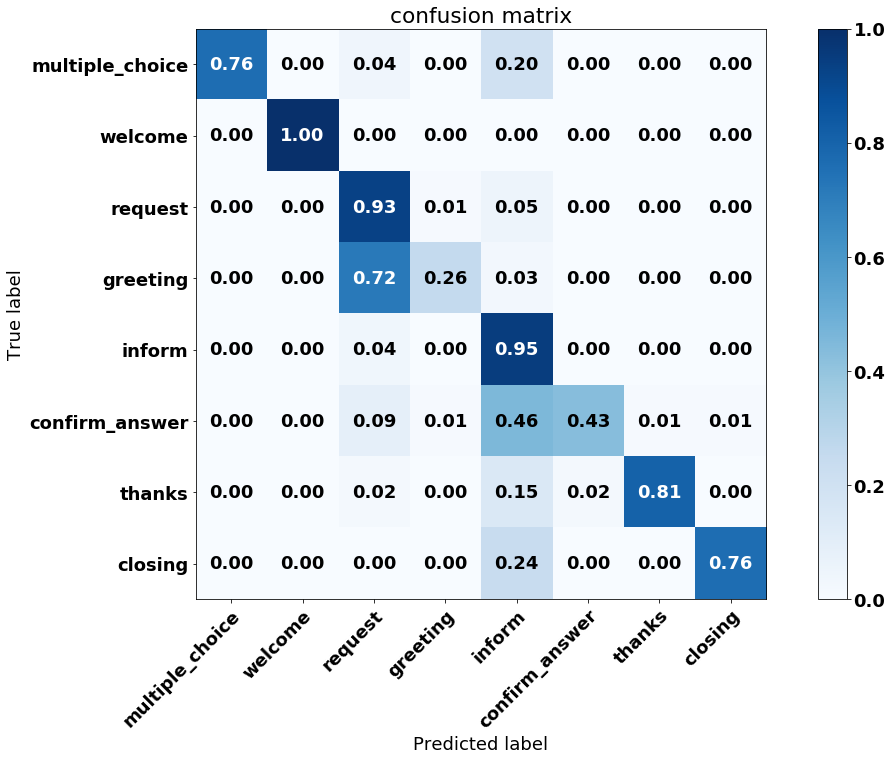

In [39]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 18}
matplotlib.rc('font', **font)
plot_confusion_matrix(np.argmax(val_Y, axis=1), y_pred, classes=target_names, normalize=True, title='confusion matrix')
plt.show()

In [40]:
def predictions(text):
    clean = re.sub(r'[^ a-z A-Z 0-9]', " ", text)
    test_word = word_tokenize(clean)
    test_word = [w.lower() for w in test_word]
    test_ls = word_tokenizer.texts_to_sequences(test_word)
    print(test_word)
    #Check for unknown words
    if [] in test_ls:
        test_ls = list(filter(None, test_ls))

    test_ls = np.array(test_ls).reshape(1, len(test_ls))

    x = padding_doc(test_ls, max_length)
    print(x.shape)

#     pred = model.predict_proba(x)
    pred = model.predict_classes(x)


    return pred

In [41]:
def get_final_output(pred, classes):
    predictions = pred[0]
    classes = np.array(classes) 
    ids = np.argsort(-predictions)
    classes = classes[ids]
    predictions = -np.sort(-predictions)
    predict = list(predictions).index(max(predictions))
    print(predict)
    print(classes[predict])
    

#     for i in range(pred.shape[1]):
#         print("%s has confidence = %s" % (classes[i], (predictions[i])))



In [42]:
text = "can i get your name?"
pred = predictions(text)
print(pred)
# get_final_output(pred, unique_intent)
print(unique_intent)
str(unique_intent[pred[0]])

['can', 'i', 'get', 'your', 'name']
(1, 25)
[2]
[u'multiple_choice', u'welcome', u'request', u'greeting', u'inform', u'confirm_answer', u'thanks', u'closing']


'request'